# Netflix Originals Project - Dataset Creation

- The goal  of this set of projects is to exemplify relevant data science skills whilst using data that will be web scraped from the Netflix Original Films wikipedia page.
- This first notebook will be focused on creating the Netflix Originals Dataset, via web scraping and communications with the OMDb API.
- Future Notebooks will use this dataset to create an Exploratory Data Analysis Notebook, an IMDb Score prediction model and an interactive film recommendation engine.

- The aim of this notebook is to:
    - Scrape relevant data from wikipedia relating to Netflix Original Films.
    - Supplement missing data with data from the OMDb API.
    - Clean and Preprocess the dataset, ready for projects in future notebooks.


---
## Step 1 : Web Scraping Wikipedia

In [4]:
import os #controlling directories, environmental variables.
import requests #useful for making http requests
from bs4 import BeautifulSoup as bs #parsing html content
import pandas as pd #DataFrame manipulation
import numpy as np #numerical computations and working with arrays.
import html5lib #helps parse a html document even if it is not well structured.
import re #working with regular expressions
import time #to web scrape ethically
import ast #used to safely evaluate lists/dictionairies that are represented as strings.

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


os.chdir(r"C:\Users\oskar\Documents\Projects\Portfolio Projects\Netflix-Originals")
os.getcwd()

'C:\\Users\\oskar\\Documents\\Projects\\Portfolio Projects\\Netflix-Originals'

---
### Extracting Data Rows from Wikipedia infoboxes


- The function 'get_infobox' in the code block below is designed to retreive and clean HTML code for a given wikipedia URL's infobox.

In [5]:
all_dicts=[] #An empty list is initialised - this will hold many dictionaries containing key-value pairs from a given films infobox.

def get_infobox(soup): #a function to extract the info-box for a single film.

    def clean_tags(soup): #this function takes a Beautiful soup object.
        for tag in soup.find_all(["sup", "span"]): #find_all locates all of the <sup> and <span> tags.
            tag.decompose() # each tag that is found to be sup or span is decomposed

    clean_tags(soup) #above inner function is called on the soup object.
    # We do this to ensure that the HTML object is clean before scraping occurs.

    def get_content_value(element): #for extracting text from a given html element.
        if element.find("li"):
            return [li.get_text(" ", strip=True).replace("\xa0"," ") for li in element.find_all("li")]
            #if the element contains list tags, a list with the text values is returned.
            #text is also sanitised here.
        else:
            return element.get_text(" ", strip=True).replace("\xa0"," ") #if not a list element, simply returned as a string


    def remove_text_within_parentheses(input_string): #a function that removes text in brackets - sometimes more info than necessary is presented.
        return re.sub(r'\([^)]*\)', '', input_string) #any expression matching from input_string is matched with "".

    infobox = soup.select("table.infobox.vevent") #infoboxes are defined as HTML tables with the classes infobox and vevent.
    if infobox: #if an infobox is found...
        info_rows = infobox[0].find_all("tr") #... all table rows are retrieved
    else:
        print("No Infobox found") #if no infobox, error message is printed and exception raised to stop the program.
        raise Exception("No Infobox found")
            
    info_dict={} #dictionairy initialised that will store key-value paris from each row of the infobox.

    for index, row in enumerate(info_rows):
        if index == 0: #if the current row has index of 0...(first row in table)
            header = row.find("th") #searches for the first table header and stores in header variable.
            if header is not None: #if a header exists...
                info_dict["Title"] = header.get_text(" ",strip=True)#... text is extracted and stored as a value under a key "Title"
        elif index > 1: #rows after index 0 will be film information.
            header = row.find("th")
            if header is not None:
                key = header.get_text(" ", strip=True) #defining the key for a given row
                cell = row.find("td") 
                if cell is not None:
                    value = get_content_value(cell) #extract text info from the HTML.
                    if isinstance(value, list):  # If value is a list, apply function to each string in the list
                        final_value = [remove_text_within_parentheses(string) for string in value]
                    else:  # If value is a single string, apply function directly
                        final_value = remove_text_within_parentheses(value)
                    info_dict[key] = final_value  # Store final_value instead of value
                
    all_dicts.append(info_dict)


- regular expression: \([^)]*\)
    - backslashes represent escape characters
    - square brackets are a character set : [^)]* - asterisk indicates 0 or more of the given set.
    - the expression matches a string that starts with "(" , followed by any amount of non ")" characters, and then ends with a ")".
    
    

---
### Accessing the page of films for each year group
- There are multiple wikipedia pages dedicated to each time period, as can be seen here: https://en.wikipedia.org/wiki/Lists_of_Netflix_original_films

In [6]:
# gather links for all films/infoboxes
r = requests.get("https://en.wikipedia.org/wiki/Lists_of_Netflix_original_films") 
soup = bs(r.content) #retrieve html for the page that stores the sublinks to each list of films
ul_items = soup.select("div.mw-parser-output ul")[0]
li_items = ul_items.find_all("li")


links = [] #initiate a list to store links in.

for item in li_items:
    a_tags = item.find_all("a")
    for a in a_tags:
        links.append(a["href"])

links #a list of link extensions for each hyperlink on the page.

['/wiki/List_of_Netflix_original_films_(2015%E2%80%932017)',
 '/wiki/List_of_Netflix_original_films_(2018)',
 '/wiki/List_of_Netflix_original_films_(2019)',
 '/wiki/List_of_Netflix_original_films_(2020)',
 '/wiki/List_of_Netflix_original_films_(2021)',
 '/wiki/List_of_Netflix_original_films_(2022)',
 '/wiki/List_of_Netflix_original_films_(since_2023)']

---
### Grab all film links from each year group

In [7]:
full_urls=[]
base_url = "https://en.wikipedia.org"
for link in links:
    full_urls.append(base_url + link) #using the links retrieved above, creating the entire link


film_links = [] # contains all movie links which we can then pass to the get_infobox function

for url in full_urls:
    r = requests.get(url)
    soup = bs(r.content)
    table_info = soup.select("table.wikitable.sortable tbody tr")[1:]
        
    for data in table_info:
        film_link = data.select("td i a")
        if film_link:
            link  = film_link[0]["href"]
            film_links.append(link)

#film_links # these are the full links for each separate wikipedia page, which has a list of films per time period.


In [8]:
for index, link in enumerate(film_links):
    base_url = "https://en.wikipedia.org"
    full_url = base_url + link 
    r = requests.get(full_url)
    soup = bs(r.content)

    try: # as some links may not have an infobox
        get_infobox(soup)
    except Exception:
        continue
    #print(index)
    #This scrapes all data that we have requested. Can take a while on some systems.

No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found
No Infobox found


---
#### Load in the following csv each time notebook is ran to prevent overload of wikipedia servers via scraping.

In [9]:
net_org = pd.DataFrame(all_dicts)
net_org.to_csv("net_org.csv")

In [10]:
netflix = pd.read_csv("net_org.csv")
#pd.set_option('display.max_columns', None)
display(len(netflix))

netflix.head(5)

993

,Unnamed: 0,Title,Directed by,Screenplay by,Based on,Produced by,Starring,Cinematography,Edited by,Music by,Production companies,Distributed by,Release dates,Running time,Country,Languages,Budget,Box office,Written by,Production company,Release date,Language,Countries,Story by,Spanish,Narrated by,Country of origin,Original language,Producers,Editor,Original release,Location,Associated album,Start date,End date,Legs,No. of shows,Supporting acts,Attendance,Composer,Executive producers,French,Venue,Kanji,Literal meaning,Transcriptions,Revised Hepburn,Traditional Chinese,Simplified Chinese,Hanyu Pinyin,Genre,Created by,Editors,Released,Length,Label,Producer,Executive producer,Original network,Portuguese,Animation by,Hangul,Revised Romanization,Turkish,Italian,Voices of,Original languages,No. of seasons,No. of episodes,Indonesian,German,Literally,Norwegian,Polish,Dutch,Hanja,Swedish,Music,Lyrics,Book,Basis,Productions,Composers,Camera setup,Date,Attack type,Weapon,Victim,Perpetrator,Motive,Accused,Convictions,Outcome,Sentence,McCune–Reischauer,Production locations,Unnamed: 96,Recorded,Original work,Owner,Years,Film(s),Television series,Video game(s),Toy(s),Comics,Short film(s),Web series,Animated series,Television special(s),Play(s),Novel(s),Traditional
0,0,Beasts of No Nation,Cary Joji Fukunaga,Cary Joji Fukunaga,Beasts of No Nation by Uzodinma Iweala,"['Amy Kaufman', 'Cary Joji Fukunaga', 'Daniela...","['Idris Elba', 'Kurt Egyiawan', 'Jude Akuwudik...",Cary Joji Fukunaga,"['Mikkel E. G. Nielsen', 'Pete Beaudreau']",Dan Romer,"['Participant Media', 'Red Crown Productions',...","['Netflix', 'Bleecker Street']","['September 3, 2015 ', 'October 16, 2015 ']",138 minutes,United States,"['English', 'Krio', 'Twi']",$6 million,"$90,777",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,The Ridiculous 6,Frank Coraci,NaN,NaN,"['Adam Sandler', 'Allen Covert', 'Ted Sarandos']","['Adam Sandler', 'Terry Crews', 'Jorge Garcia'...",Dean Semler,Tom Costain,"['Rupert Gregson-Williams', 'Elmo Weber']",NaN,Netflix,NaN,120 minutes,United States,NaN,$60 million,NaN,"['Tim Herlihy', 'Adam Sandler']",Happy Madison Productions,"['December 11, 2015']",English,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Pee-wee's Big Holiday,John Lee,NaN,NaN,"['Judd Apatow', 'Paul Reubens']","['Paul Reubens', 'Joe Manganiello']",Tim Orr,Jeff Buchanan,Mark Mothersbaugh,"['Pee-wee Pictures', 'Apatow Productions']",Netflix,"['March 17, 2016 ', 'March 18, 2016 ']",89 minutes,United States,NaN,NaN,NaN,"['Paul Reubens', 'Paul Rust']",NaN,NaN,English,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Special Correspondents,Ricky Gervais,NaN,Envoyés très spéciaux by Simon Michaël & Jacqu...,"['Chris Coen', 'Aaron L. Gilbert', 'Ricky Gerv...","['Ricky Gervais', 'Eric Bana', 'Vera Farmiga',...",Terry Stacey,Nicolas Chaudeurge,Dickon Hinchliffe,"['Bron Studios', 'Unanimous Entertainment']",Netflix,"['22 April 2016 ', '29 April 2016 ']",100 minutes,NaN,NaN,NaN,NaN,Ricky Gervais,NaN,NaN,English,"['Canada', 'United States']",NaN,Na

Given that this dataset will be used to complete 2 different projects in the future, I would like to include the following variables:
- Title
- Genres*
- Cast
- Directors
- Release Year
- Runtime
- Description*
- IMDb Rating*
- Financials (Budget/Revenue)*
- Country
- Production Company   
- Rated
- Wins/Nominations
- IMDb Votes

*Need to extract from a different data source as either entirely not available or too many missing values in scraped data.

- Netflix are not very open with their budgets for their original productions (As seen from OMDb API data collection).
- Furthermore, as Netflix is a streaming service, the vast majority of its originals are not shown in Theatres and therefore have no Box Office scores.
- I do not think there is an adequate replacement for a productions budget, however, I think there are some similarities between the number of IMDb votes and the Box Office of a film. Awards that each film receives also has similarities to Box Office

In [11]:
netflix["Production companies"].replace("NaN", np.nan, inplace=True) #replacing strubg NaN values with np.nan values
netflix['Production companies'] = netflix['Production companies'].fillna(netflix['Production company']) #filling missing values with values from a similar column.

In [12]:
cols_to_keep = ["Title", "Starring", "Directed by", "Release dates", "Running time", "Country", "Production companies" ] #Filtering out all the unnecessary columns.

netflix = netflix[cols_to_keep]
netflix.head()

,Title,Starring,Directed by,Release dates,Running time,Country,Production companies
0,Beasts of No Nation,"['Idris Elba', 'Kurt Egyiawan', 'Jude Akuwudik...",Cary Joji Fukunaga,"['September 3, 2015 ', 'October 16, 2015 ']",138 minutes,United States,"['Participant Media', 'Red Crown Productions',..."
1,The Ridiculous 6,"['Adam Sandler', 'Terry Crews', 'Jorge Garcia'...",Frank Coraci,NaN,120 minutes,United States,Happy Madison Productions
2,Pee-wee's Big Holiday,"['Paul Reubens', 'Joe Manganiello']",John Lee,"['March 17, 2016 ', 'March 18, 2016 ']",89 minutes,United States,"['Pee-wee Pictures', 'Apatow Productions']"
3,Special Correspondents,"['Ricky Gervais', 'Eric Bana', 'Vera Farmiga',...",Ricky Gervais,"['22 April 2016 ', '29 April 2016 ']",100 minutes,NaN,"['Bron Studios', 'Unanimous Entertainment']"
4,The Do-Over,"['Adam Sandler', 'David Spade', 'Paula Patton'...",Steve Brill,"['May 16, 2016 ', 'May 27, 2016 ']",108 minutes,United States,Happy Madison Productions


In [13]:
# Rename column labels
new_col_names = {"Starring":"Cast",
                 "Directed by":"Director",
                 "Release dates": "Release Date",
                 "Running time":"Running Time",
                 "Production companies": "Production Company"} #using dictionairies to rename columns.

netflix = netflix.rename(columns = new_col_names)

netflix.head()

,Title,Cast,Director,Release Date,Running Time,Country,Production Company
0,Beasts of No Nation,"['Idris Elba', 'Kurt Egyiawan', 'Jude Akuwudik...",Cary Joji Fukunaga,"['September 3, 2015 ', 'October 16, 2015 ']",138 minutes,United States,"['Participant Media', 'Red Crown Productions',..."
1,The Ridiculous 6,"['Adam Sandler', 'Terry Crews', 'Jorge Garcia'...",Frank Coraci,NaN,120 minutes,United States,Happy Madison Productions
2,Pee-wee's Big Holiday,"['Paul Reubens', 'Joe Manganiello']",John Lee,"['March 17, 2016 ', 'March 18, 2016 ']",89 minutes,United States,"['Pee-wee Pictures', 'Apatow Productions']"
3,Special Correspondents,"['Ricky Gervais', 'Eric Bana', 'Vera Farmiga',...",Ricky Gervais,"['22 April 2016 ', '29 April 2016 ']",100 minutes,NaN,"['Bron Studios', 'Unanimous Entertainment']"
4,The Do-Over,"['Adam Sandler', 'David Spade', 'Paula Patton'...",Steve Brill,"['May 16, 2016 ', 'May 27, 2016 ']",108 minutes,United States,Happy Madison Productions


---
## Step 2: Communicate with OMDb API for additional data
-  Note: £1 fee paid for 100,000 daily API requests

In [14]:
netflix["Title"] = netflix["Title"].astype(str)
netflix.dtypes

Title                 object
Cast                  object
Director              object
Release Date          object
Running Time          object
Country               object
Production Company    object
dtype: object


- Creating new columns to store OMDb data in.

In [15]:
netflix["IMDb Score"] = ''
netflix["Genre"]= ''
netflix["Description"]= ''
netflix["Box Office"]= ''
netflix["Wins_Nominations"]= ''
netflix["IMDb Votes"]=''
netflix["Rated"]= ''
netflix["Type"]=''
netflix["Cast"]=''
netflix["Country"]=''

api_key = os.getenv('API_KEY') #api key stored as an environment variable - you can hard code your own key here.

for index, row in netflix.iterrows():      
    movie_name = row["Title"].replace(" ", "+") # replace spaces with '+' to correctly format the search query
    
    url = f'http://www.omdbapi.com/?t={movie_name}&apikey={api_key}'

    response = requests.get(url)

    if response.status_code == 200: #if a connection is made...
        data = response.json() #response data is stored in data variable.
        if "imdbRating" in data:
            netflix.loc[index, 'IMDb Score'] = data['imdbRating'] #At the given index in the Imdb column, insert the relevant imdb rating data.
        else:
            print(f"Could not find IMDb rating for movie: {row['Title']}") #If imdb data is not present, print the messate.
        
        # check if the movie has a genre
        if 'Genre' in data:
            netflix.loc[index, 'Genre'] = data['Genre']
        else:
            print(f"Could not find genre for movie: {row['Title']}")
        
        # check if the movie has a plot ... and so on for the other columns.
        if 'Plot' in data:
            netflix.loc[index, 'Description'] = data['Plot']
        else:
            print(f"Could not find plot for movie: {row['Title']}")
        
        if 'Awards' in data:
            netflix.loc[index, 'Wins_Nominations'] = data['Awards']
        else:
            print(f"Could not find Awards for movie: {row['Title']}")

        if 'imdbVotes' in data:
            netflix.loc[index, 'IMDb Votes'] = data['imdbVotes']
        else:
            print(f"Could not find IMDb Votes for movie: {row['Title']}")

        if 'Rated' in data:
            netflix.loc[index, 'Rated'] = data['Rated']
        else:
            print(f"Could not find rating for movie: {row['Title']}")

        if 'Type' in data:
            netflix.loc[index, 'Type']= data['Type']
        else:
            print(f"Could not find type for movie: {row['Title']}")

        if 'Actors' in data:
            netflix.loc[index, 'Cast']= data['Actors']
        else:
            print(f"Could not find type for movie: {row['Title']}")

        if 'Country' in data:
            netflix.loc[index, 'Country']= data['Country']
        else:
            print(f"Could not find Country for movie: {row['Title']}")



Could not find IMDb rating for movie: Reality High
Could not find genre for movie: Reality High
Could not find plot for movie: Reality High
Could not find Awards for movie: Reality High
Could not find IMDb Votes for movie: Reality High
Could not find rating for movie: Reality High
Could not find type for movie: Reality High
Could not find type for movie: Reality High
Could not find Country for movie: Reality High
Could not find IMDb rating for movie: The Meyerowitz Stories (New and Selected)
Could not find genre for movie: The Meyerowitz Stories (New and Selected)
Could not find plot for movie: The Meyerowitz Stories (New and Selected)
Could not find Awards for movie: The Meyerowitz Stories (New and Selected)
Could not find IMDb Votes for movie: The Meyerowitz Stories (New and Selected)
Could not find rating for movie: The Meyerowitz Stories (New and Selected)
Could not find type for movie: The Meyerowitz Stories (New and Selected)
Could not find type for movie: The Meyerowitz Stories 

In [16]:
netflix.to_csv("net_org_omdb.csv") #Creating a new csv save to prevent having to run all the above code each time notebook is refreshed.

In [17]:
netflix=pd.read_csv("net_org_omdb.csv")
netflix.head(5)
netflix = netflix[["Title","Description","Genre","Rated","Type","Running Time", "Release Date" ,"Director", "Cast","Country","Production Company", "Wins_Nominations", "IMDb Votes", "IMDb Score"]]


---
## Step 3 : Data Cleaning (Missing Values + Incorrect Categorisation)
- Dealing with duplicate entries

In [18]:
netflix[netflix.duplicated()] # returns 34 duplicated rows
netflix = netflix.drop_duplicates()
netflix[netflix.duplicated()] #No duplicate rows remaining

,Title,Description,Genre,Rated,Type,Running Time,Release Date,Director,Cast,Country,Production Company,Wins_Nominations,IMDb Votes,IMDb Score


---
### Type
- Projects are focused on films, not series. Therefore, we want to remove any media types that are under 'series'.

<AxesSubplot:>

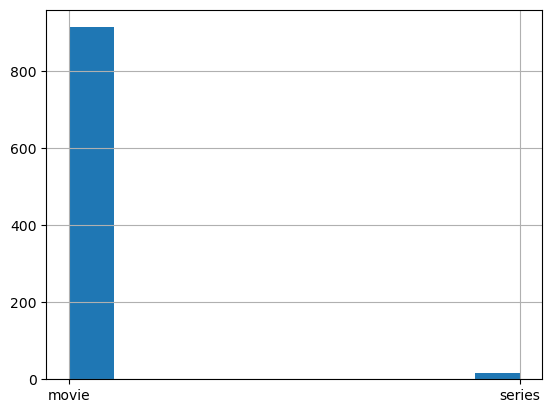

In [19]:
netflix['Type'].hist()

In [20]:
netflix = netflix[netflix["Type"]=="movie"] #Using Boolean indexing to create a new dataframe with only movies.
netflix.head()

,Title,Description,Genre,Rated,Type,Running Time,Release Date,Director,Cast,Country,Production Company,Wins_Nominations,IMDb Votes,IMDb Score
0,Beasts of No Nation,"A drama based on the experiences of Agu, a chi...","Drama, War",TV-MA,movie,138 minutes,"['September 3, 2015 ', 'October 16, 2015 ']",Cary Joji Fukunaga,"Abraham Attah, Emmanuel Affadzi, Ricky Adelayitor",United States,"['Participant Media', 'Red Crown Productions',...",Nominated for 1 BAFTA Award31 wins & 59 nomina...,"85,149",7.7
1,The Ridiculous 6,An outlaw who was raised by Native Americans d...,"Action, Adventure, Comedy",TV-14,movie,120 minutes,NaN,Frank Coraci,"Adam Sandler, Terry Crews, Jorge Garcia",United States,Happy Madison Productions,NaN,"52,165",4.8
2,Pee-wee's Big Holiday,A fateful meeting with a mysterious stranger i...,"Comedy, Family",TV-PG,movie,89 minutes,"['March 17, 2016 ', 'March 18, 2016 ']",John Lee,"Paul Reubens, Jordan Black, Doug Cox",United States,"['Pee-wee Pictures', 'Apatow Productions']",NaN,"8,871",6.1
3,Special Correspondents,A radio journalist and his technician get in o...,Comedy,TV-MA,movie,100 minutes,"['22 April 2016 ', '29 April 2016 ']",Ricky Gervais,"Ricky Gervais, Eric Bana, Vera Farmiga","Canada, United Kingdom, United States","['Bron Studios', 'Unanimous Entertainment']",NaN,"25,650",5.9
4,The Do-Over,Two down-on-their-luck guys decide to fake the...,"Action, Adventure, Comedy",TV-MA,movie,108 minutes,"['May 16, 2016 ', 'May 27, 2016 ']",Steve Brill,"Adam Sandler, David Spade, Paula Patton",United States,Happy Madison Productions,NaN,"49,828",5.7


---
### Title

In [21]:
netflix["Title"] = netflix["Title"].astype('string')
display(netflix["Title"].dtype)
netflix["Title"].isna().sum()

string[python]

1

---
### Description

In [22]:
netflix["Description"].value_counts() #view any issues with the descriptions column. 
missing_descriptions = netflix[(netflix["Description"]=="")|(netflix["Description"]=="N/A")] #identifying any missing description columns.
netflix = netflix.drop(missing_descriptions.index) 
netflix["Description"] = netflix["Description"].astype("string") #cleaning and converting to more ideal data types.

---
### Ratings

In [23]:
netflix["Rated"].isna().sum()#111 na values
netflix["Rated"] = netflix["Rated"].fillna("Not Rated") #Instead of being an NA, renaming these columns to 'Not Rated' 
netflix["Rated"].isna().sum()


0

In [24]:
netflix["Rated"].value_counts()

TV-MA        312
R            134
TV-14        134
Not Rated    126
PG-13         67
TV-PG         59
PG            44
TV-G          13
TV-Y7          6
Unrated        5
G              4
TV-Y7-FV       2
16+            2
Approved       1
E              1
12             1
MA-17          1
NC-17          1
Passed         1
Name: Rated, dtype: int64

- Creating a mapping in order to combine ratings into fewer and more distinct categories
- Many of the pre-existing categories overlap with each other/mean the same thing.
- The mapping below groups similar categories succinctly.

In [25]:
rating_new_cat = {
    'TV-Y7': 'General Audiences',
    'TV-Y7-FV': 'General Audiences',
    'G': 'General Audiences',
    'E': 'General Audiences',
    'Approved': 'General Audiences',
    'Passed': 'General Audiences',
    'TV-G': 'Parental Guidance',
    'TV-PG': 'Parental Guidance',
    'PG': 'Parental Guidance',
    'PG-13': 'Parental Guidance',
    'TV-14': 'Mature Audiences',
    'R': 'Mature Audiences',
    'NC-17': 'Mature Audiences',
    'TV-MA': 'Mature Audiences',
    'MA-17': 'Mature Audiences',
    'N/A': 'Not Rated',
    'Not Rated': 'Not Rated',
    'Unrated': 'Not Rated',
    '12': 'Parental Guidance',
    '16+': 'Mature Audiences'
}

netflix["Rated"] = netflix["Rated"].replace(rating_new_cat)
netflix["Rated"].value_counts()

Mature Audiences     584
Parental Guidance    184
Not Rated            131
General Audiences     15
Name: Rated, dtype: int64

In [26]:
netflix["Rated"] = pd.Categorical(netflix["Rated"]) #Converting this column to categorical data type.
netflix["Rated"].dtype

CategoricalDtype(categories=['General Audiences', 'Mature Audiences', 'Not Rated',
                  'Parental Guidance'],
, ordered=False)

---
### Running Time

In [27]:
netflix["Running Time"].unique()
netflix["Running Time"].isna().sum()

88

In [28]:
netflix["Running Time"] = netflix["Running Time"].astype(str)
netflix["Running Time"] = netflix["Running Time"].str.strip() #removing any leading or trailing whitespaces.

#Dealing with edge cases
def clean_runtime(value):
    try:
        value_list = ast.literal_eval(value)  # Convert the string to a list, even though presented initially as a string
        if isinstance(value_list, list):
            return value_list[0]  # Return first list item
    except (ValueError, SyntaxError):
        pass
    return value

netflix["Running Time"] = netflix["Running Time"].apply(clean_runtime)
netflix["Running Time"] = netflix["Running Time"].str.strip()

#manually replacing times that were input in incorrect format on wikipedia
netflix["Running Time"] = netflix["Running Time"].str.replace(" minutes","")
netflix["Running Time"] = netflix["Running Time"].str.replace("1h 17min","77")
netflix["Running Time"] = netflix["Running Time"].str.replace("1 hour","60")
netflix["Running Time"] = netflix["Running Time"].str.replace("1h 44minutes","104")
netflix["Running Time"] = netflix["Running Time"].str.replace("25-36","30")
netflix["Running Time"] = netflix["Running Time"].str.replace("Variable; approx. 15","15")
netflix["Running Time"] = netflix["Running Time"].str.replace("min","")
netflix["Running Time"] = netflix["Running Time"].str.replace("60, 37","")

netflix["Running Time"].replace('nan', np.nan, inplace=True) #np.nan is used in conjunction with float values.
netflix["Running Time"].replace('', np.nan, inplace=True)

not_film = netflix[netflix["Running Time"]=="2-3"] #series was mislabelled as a movie. Needed to be removed.
netflix = netflix.drop(not_film.index, axis=0)

netflix["Running Time"] = netflix["Running Time"].astype(float)

netflix["Running Time"].unique()

C:\Users\oskar\AppData\Local\Temp\ipykernel_17676\779439805.py:23: FutureWarning: The default value of regex will change from True to False in a future version.
  netflix["Running Time"] = netflix["Running Time"].str.replace("Variable; approx. 15","15")


array([138., 120.,  89., 100., 108.,  93.,  95., 101., 111.,  92.,  88.,
        87.,  77.,  98.,  90., 107.,  97., 104.,  80.,  70.,  96., 102.,
        nan,  91., 131., 113.,  83.,  81., 106., 122., 136., 103.,  85.,
        82., 118.,  84., 115.,  79.,  24.,  40.,  76., 121.,  26.,  39.,
       105., 109.,  94.,  73., 114.,  56.,  54.,  52., 133., 126.,  78.,
        74., 116.,  99., 125., 123., 143., 129., 135., 124.,  23.,  12.,
        86.,  57.,  59.,  58.,  34.,  30., 132., 110.,  72., 130.,  71.,
       151., 140., 119., 209., 137., 128.,  64.,  25.,  48.,  29.,  37.,
        21.,  51.,  28.,  19.,  62.,  60.,  32.,  45., 144., 117., 112.,
       134., 149., 156., 139., 150.,  17.,  16.,  75.,  41.,  15.,  49.,
        42.,   9., 142., 127., 148., 158., 189., 141., 159.,  53.,  55.,
        68.,  69., 166., 147., 174.,  22., 157.])

In [29]:
display(netflix["Running Time"].isna().sum()) #92 NA values 

api_key = os.getenv('API_KEY')

def fetch_runtime(title): #building a function to retrieve data from the OMDb api.
    try:
        response = requests.get(f"http://www.omdbapi.com/?t={title.replace(' ', '+')}&apikey={api_key}")
        data = response.json()
                
        if data.get("Response") == "False":
            return np.nan
                
        runtime_str = data.get("Runtime", "")
        runtime_val = int(runtime_str.split()[0]) if "min" in runtime_str else np.nan #converts string into integer
        return runtime_val
    except Exception:
        return np.nan

# Identify rows with missing "Running Time" and update them
missing_indices = netflix[netflix["Running Time"].isna()].index

for index in missing_indices:
    title = netflix.loc[index, "Title"]
    netflix.loc[index, "Running Time"] = fetch_runtime(title)

display(netflix["Running Time"].isna().sum()) # Now there are only 14 na values, which we can either drop or fillna

89

13

dtype('int32')

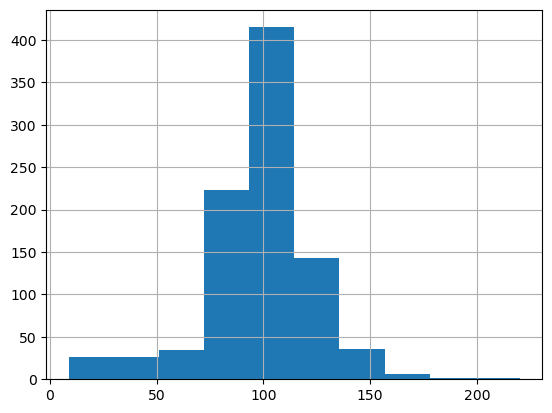

In [30]:
mean_running_time = round(netflix["Running Time"].mean())
netflix["Running Time"] = netflix["Running Time"].fillna(mean_running_time) #impute mean for missing values
netflix["Running Time"].isna().sum() # There are now no missing values in the Running Time Column

netflix["Running Time"] = netflix["Running Time"].astype(int)
netflix["Running Time"].hist() #Data is now clean, complete and in integer form.

netflix["Running Time"].dtype


---
### Release Date

In [31]:
netflix["Release Date"].isna().sum() #similarly to the above instance, there are a lot of missing values (505), so I will import the rest of the missing data from the OMDb API
api_key = os.getenv('API_KEY')

def fetch_release(title):
    try:
        response = requests.get(f"http://www.omdbapi.com/?t={title.replace(' ', '+')}&apikey={api_key}")
        data = response.json()
                
        if data.get("Response") == "False":
            return np.nan
                
        release_str = data.get("Released", "")        
        return release_str
    except Exception:
        return np.nan

# Identify rows with missing "Running Time" and update them
missing_indices = netflix[netflix["Release Date"].isna()].index

for index in missing_indices:
    title = netflix.loc[index, "Title"]
    netflix.loc[index, "Release Date"] = fetch_release(title)

display(netflix["Release Date"].isna().sum()) 

1

In [32]:
#most data is now present  #one film lacks a release date + title so can be dropped.
rows_to_drop = netflix[netflix["Release Date"].isna()].index
netflix = netflix.drop(rows_to_drop)
netflix["Release Date"].isna().sum()

0

In [36]:
def clean_release(value):
    try:
        value_list = ast.literal_eval(value) #trying to evaluate the string value as a literal value.
        if isinstance(value_list, list):#if a list, the first item is returned.
            return value_list[0]
    except (ValueError, SyntaxError):#...unless it is a given error, in which case we pass.
        pass
    
    # select the first data
    for date_part in value.split(' '): #deals with edge cases where there are many dates in a row separated by spaces.
        try:
            return pd.to_datetime(date_part) #if successfully converted , the datetime is returned.
        except:
            continue

    return value

# Applying the function to release data column
netflix["Release Date"] = netflix["Release Date"].apply(clean_release)

# Drop na rows
rows_to_drop = netflix[netflix["Release Date"]=="N/A"].index
netflix = netflix.drop(rows_to_drop, axis=0)

# Converting release date to datetime.
try:
    netflix["Release Date"] = pd.to_datetime(netflix["Release Date"])
except Exception as e:
    print(f"An error occurred: {e}")

# Check for NA values
print(netflix["Release Date"].isna().sum())

0


In [37]:
netflix.to_csv("net_org_b4director.csv")

In [38]:
netflix=pd.read_csv("net_org_b4director.csv")

### Director


In [39]:
#This step is taken because following the web scrape from wikipedia, there are many different formats within the Director column
#This step takes an listlike strings and converts them to literal lists, which we can then work with and take the first director
#The first director(if more than one) is taken as more often than not, this is the 'lead' director.

def clean_director(director):
    try:
        dir_value = ast.literal_eval(director)
        if isinstance(dir_value, list):
            return dir_value[0]
    except (ValueError, SyntaxError):
        pass
    return director

netflix["Director"] = netflix["Director"].apply(clean_director)

In [40]:
netflix["Director"].head()

0    Cary Joji Fukunaga
1          Frank Coraci
2              John Lee
3         Ricky Gervais
4           Steve Brill
Name: Director, dtype: object

In [41]:
#Unfortunately, there are instances where no commas separate the names of directors.
#As a result, i have decided the replace these problematic instances, as well as any NA data, with OMDB data. 

missing_director_indices = netflix[netflix["Director"].isna()].index.to_list()
problematic_indices = [59,62,76,77,83,90,95,97,160,167,174,179,180,189,267,306,309,478,517,569,641,659,662,727,728,785,789,827]
all_problem_indices = set(missing_director_indices + problematic_indices)

def get_director(title):
    response = requests.get(f"http://www.omdbapi.com/?t={title.replace(' ', '+')}&apikey={api_key}")
    data = response.json()
    if "Director" in data:
        return data["Director"]
    return None    

for index in all_problem_indices:
    title = netflix.loc[index, "Title"]
    omdb_director = get_director(title)
    if omdb_director:
        netflix.loc[index, "Director"] = omdb_director

netflix["Director"] = netflix["Director"].apply(lambda x: x.split(",")[0]) #take the first director only.

In [42]:
display(netflix["Director"].value_counts().head())
netflix["Director"] = netflix["Director"].astype("string")
netflix["Director"].dtype

McG               4
Kunle Afolayan    4
Chris Smith       4
Vince Marcello    3
Leigh Janiak      3
Name: Director, dtype: int64

string[python]

---
### Cast

In [43]:
#This information has been taken straight from the OMDb API as the web scraping process resulted in very dirty data.
#Manipulation and feature engineering will occur in the later notebooks based on the project at hand.

netflix["Cast"].head()
netflix["Cast"].isna().sum() #17NA. This is the case because they are documentaries and dont have a main cast.

no_cast = netflix[netflix["Cast"].isna()].index

netflix.loc[no_cast,"Cast"] = "No Cast Available"
netflix["Cast"].head()
    

0    Abraham Attah, Emmanuel Affadzi, Ricky Adelayitor
1              Adam Sandler, Terry Crews, Jorge Garcia
2                 Paul Reubens, Jordan Black, Doug Cox
3               Ricky Gervais, Eric Bana, Vera Farmiga
4              Adam Sandler, David Spade, Paula Patton
Name: Cast, dtype: object

---
### Country

- There are instances where United States is referred to as USA. All country names need to be uniform
- Some countries are a list within a string
- There are 128 NA, as info was not available on Wikipedia

In [44]:
netflix["Country"].isna().sum()
netflix.loc[netflix["Country"].isna(), "Country"] = "United States"

In [45]:
#Upon investigation, the web scraped data was only showing 1 "Country" for each production. The OMDb data is much more detailed, listing multiple countries, rather than only USA, which is the most common country.
#I want to take the first country from each string to be the primary country of production
# A second binary column titled "International" will be made if more than 1 country took part in the production. 1 is international, 0 is single country.
netflix["Country"].head()

0                            United States
1                            United States
2                            United States
3    Canada, United Kingdom, United States
4                            United States
Name: Country, dtype: object

In [46]:
netflix["Country"].value_counts() # I can see some countries are labelled USA instead of United States
netflix['Country'] = netflix['Country'].replace("USA", "United States")
netflix["Country"].value_counts()

netflix["International"] = netflix["Country"].apply(lambda x: 1 if "," in x else 0) #creating an international column based on the Country column

display(netflix[["Title", "Country", "International"]].head(10))
#for each row in the Country column, the first country will be taken from each string, and be treated as the primary country of production.
netflix["Primary Country"] = netflix["Country"].apply(lambda country: country.split(",")[0])
netflix["Primary Country"].head(10)

,Title,Country,International
0,Beasts of No Nation,United States,0
1,The Ridiculous 6,United States,0
2,Pee-wee's Big Holiday,United States,0
3,Special Correspondents,"Canada, United Kingdom, United States",1
4,The Do-Over,United States,0
5,The Fundamentals of Caring,United States,0
6,Brahman Naman,"India, United Kingdom",1
7,Rebirth,United States,0
8,Tallulah,United States,0
9,XOXO,United States,0


0    United States
1    United States
2    United States
3           Canada
4    United States
5    United States
6            India
7    United States
8    United States
9    United States
Name: Primary Country, dtype: object

---
### Production Companies

- NOTE : OMDB API does not have data for production companies.

In [47]:
netflix = netflix.drop('Unnamed: 0', axis=1)

In [48]:
netflix["Production Company"].isna().sum() #120 NA
netflix["Production Company"]
netflix["Production Company"].value_counts()
# Converting all entries so that they are in list format

def list_conversion(entry):
    try:
        if isinstance(entry, str):
            return ast.literal_eval(entry)
        else:
            return entry
    except (SyntaxError, ValueError):
        return [entry]
    
netflix["Production Company"] = netflix["Production Company"].apply(list_conversion)

#Dealing with NA values
netflix.loc[netflix["Production Company"].isna(), "Production Company"] = "No Production Company Listed"

#Create a boolean column for films that had more than one production company involved
netflix["Multiple Production Companies"] = netflix["Production Company"].apply(lambda x: 1 if isinstance(x, (list, str)) and len(x) > 1 else 0)


#Now we want to take only the first production company from each list as it is typically the main one.
for index in netflix.index:
    company = netflix.loc[index, "Production Company"]
    if isinstance(company, list) and company:
        netflix.loc[index, "Production Company"] = company[0]

In [49]:
int_rows = netflix[netflix['Production Company'].apply(lambda x: isinstance(x, int))]
int_rows

,Title,Description,Genre,Rated,Type,Running Time,Release Date,Director,Cast,Country,Production Company,Wins_Nominations,IMDb Votes,IMDb Score,International,Primary Country,Multiple Production Companies
692,The Weekend Away,A weekend getaway to Croatia that goes awry wh...,"Crime, Drama, Mystery",Mature Audiences,movie,89,2022-01-01,Kim Farrant,"Leighton Meester, Christina Wolfe, Ziad Bakri",United States,42,1 win,"28,222",5.7,0,United States,0


In [50]:
# There are many instances where Netflix appears as "Netflix Studios", "Netflix Paris" and many other iterations, instead of just Netflix. I want to convert all Netflix-like production companies get rebranded as "Netflix".

int_rows = netflix[netflix['Production Company'].apply(lambda x: isinstance(x, int))] #The row after this was causing errors due to integers being present in the column. A company called 42 was the cause
netflix['Production Company'] = netflix['Production Company'].apply(lambda x: str(x) if isinstance(x, int) else x)

# List of popular production companies. If given company substring is in string, string is replaced by substring.
production_companies_to_rebrand = [
    "Netflix",
    "20th Century Studios",
    "T-Series",
    "Brooklyn Underground Films",
    "RSVP Movies",
    "Screen Australia",
    "Buena Vista International",
    "Silverback Films",
    "Balaji Motion Pictures",
    "YNOT Studios",
    "Sony",
    "Climax Studio",
    "Three's Company Productions",
    "JAR Pictures",
    "Dharma Productions",
    "Nickelodeon",
    "A24",
    "HTYT Films",
    "Ryan Murphy Productions",
    "Vulcan Productions",
    "Red Hour Productions",
    "Think Big Studios",
    "PalmStar Media",
    "XYZ Films",
    "Blue Creek Pictures",
    "Off The Fence",
    "Broken Road Productions",
    "Original Force Animation",
    "Annapurna Pictures",
    "Chain Camera Pictures",
    "TriBeCa Productions",
    "Jabberwockee Talkies",
    "1492 Pictures",
    "Red Chillies Entertainment",
    "India Stories Media & Entertainment",
    "Imagine Documentaries",
    "Freeborne Media",
    "SF Studios"
]

# Rebrand the production companies in the DataFrame
for prod_company in production_companies_to_rebrand:
    netflix["Production Company"] = netflix["Production Company"].apply(lambda x: prod_company if prod_company in str(x) else x)

In [51]:
netflix["Production Company"].value_counts().head(10)

No Production Company Listed    122
Netflix                          53
Happy Madison Productions        13
MPCA                              9
RSVP Movies                       8
Players' Tribune                  6
Likely Story                      6
Wonderland Sound and Vision       5
Paramount Pictures                5
Blumhouse Productions             5
Name: Production Company, dtype: int64

---
### Wins and Nominations

In [52]:
netflix["Wins_Nominations"].head(20)

0     Nominated for 1 BAFTA Award31 wins & 59 nomina...
1                                                   NaN
2                                                   NaN
3                                                   NaN
4                                                   NaN
5                                         4 nominations
6                                         2 nominations
7                                                   NaN
8                                         2 nominations
9                                                   NaN
10                                1 win & 3 nominations
11                               3 wins & 4 nominations
12                                 1 win & 1 nomination
13                                        2 nominations
14                                                1 win
15                                                  NaN
16                                                  NaN
17                                              

In [53]:
#regex will be used to extract wins and nominations for each title 
#regex patterns
pattern_wins = r'(\d+) win'
pattern_nominations = r'(\d+) nomination'

# Extract 'wins' and 'nominations' using the regex patterns and convert them to numeric form
netflix['wins'] = pd.to_numeric(netflix['Wins_Nominations'].str.extract(pattern_wins, expand=False)).fillna(0).astype(int) #expand = false to produced a series rather than df
netflix['nominations'] = pd.to_numeric(netflix['Wins_Nominations'].str.extract(pattern_nominations, expand=False)).fillna(0).astype(int)

netflix.head()

,Title,Description,Genre,Rated,Type,Running Time,Release Date,Director,Cast,Country,Production Company,Wins_Nominations,IMDb Votes,IMDb Score,International,Primary Country,Multiple Production Companies,wins,nominations
0,Beasts of No Nation,"A drama based on the experiences of Agu, a chi...","Drama, War",Mature Audiences,movie,138,2015-01-01,Cary Joji Fukunaga,"Abraham Attah, Emmanuel Affadzi, Ricky Adelayitor",United States,Participant Media,Nominated for 1 BAFTA Award31 wins & 59 nomina...,"85,149",7.7,0,United States,1,31,59
1,The Ridiculous 6,An outlaw who was raised by Native Americans d...,"Action, Adventure, Comedy",Mature Audiences,movie,120,2015-01-01,Frank Coraci,"Adam Sandler, Terry Crews, Jorge Garcia",United States,Happy Madison Productions,NaN,"52,165",4.8,0,United States,0,0,0
2,Pee-wee's Big Holiday,A fateful meeting with a mysterious stranger i...,"Comedy, Family",Parental Guidance,movie,89,2016-01-01,John Lee,"Paul Reubens, Jordan Black, Doug Cox",United States,Pee-wee Pictures,NaN,"8,871",6.1,0,United States,1,0,0
3,Special Correspondents,A radio journalist and his technician get in o...,Comedy,Mature Audiences,movie,100,2016-01-01,Ricky Gervais,"Ricky Gervais, Eric Bana, Vera Farmiga","Canada, United Kingdom, United States",Bron Studios,NaN,"25,650",5.9,1,Canada,1,0,0
4,The Do-Over,Two down-on-their-luck guys decide to fake the...,"Action, Adventure, Comedy",Mature Audiences,movie,108,2016-01-01,Steve Brill,"Adam Sandler, David Spade, Paula Patton",United States,Happy Madison Productions,NaN,"49,828",5.7,0,United States,0,0,0


---
### IMDb Votes

In [54]:
netflix["IMDb Votes"].isna().sum()
#Although there are 14 NA values, we will keep the DF the same. We will edit accordingly as we complete the two future projects
#Currently string values with commas. Need to remove commas so that can convert to integers

def clean_and_convert(votes):
    if isinstance(votes, str):
        remove_comma = votes.replace(",", "")
        return int(remove_comma)
    return votes

netflix["IMDb Votes"] = netflix["IMDb Votes"].apply(clean_and_convert)
netflix["IMDb Votes"] = netflix["IMDb Votes"].astype('Int64')

---
### IMDb Score

In [55]:
netflix = netflix.iloc[:881]
netflix["IMDb Score"].isna().sum() #17 missing values. Can be dealt with accordingly in future notebooks
netflix["IMDb Score"].dtype

dtype('float64')

---
### Re-Organising DataFrame Columns

In [56]:
netflix = netflix[['Title', 'Description', 'Genre', 'Rated', 'Type', 'Running Time',
       'Release Date', 'Director', 'Cast', 'Primary Country', 'International','Production Company','Multiple Production Companies',
       'wins','nominations', 'IMDb Votes', 'IMDb Score' ]]
netflix = netflix.rename(columns={'wins': 'Wins',
                        'nominations':'Nominations',
                        'Running Time':'Running Time(mins)',
                        'Production Company':'Lead Production Company'})

netflix = netflix.drop("Type",axis=1)

In [57]:
display(netflix.dtypes)
netflix.head()

Title                             object
Description                       object
Genre                             object
Rated                             object
Running Time(mins)                 int64
Release Date                      object
Director                          string
Cast                              object
Primary Country                   object
International                      int64
Lead Production Company           object
Multiple Production Companies      int64
Wins                               int32
Nominations                        int32
IMDb Votes                         Int64
IMDb Score                       float64
dtype: object

,Title,Description,Genre,Rated,Running Time(mins),Release Date,Director,Cast,Primary Country,International,Lead Production Company,Multiple Production Companies,Wins,Nominations,IMDb Votes,IMDb Score
0,Beasts of No Nation,"A drama based on the experiences of Agu, a chi...","Drama, War",Mature Audiences,138,2015-01-01,Cary Joji Fukunaga,"Abraham Attah, Emmanuel Affadzi, Ricky Adelayitor",United States,0,Participant Media,1,31,59,85149,7.7
1,The Ridiculous 6,An outlaw who was raised by Native Americans d...,"Action, Adventure, Comedy",Mature Audiences,120,2015-01-01,Frank Coraci,"Adam Sandler, Terry Crews, Jorge Garcia",United States,0,Happy Madison Productions,0,0,0,52165,4.8
2,Pee-wee's Big Holiday,A fateful meeting with a mysterious stranger i...,"Comedy, Family",Parental Guidance,89,2016-01-01,John Lee,"Paul Reubens, Jordan Black, Doug Cox",United States,0,Pee-wee Pictures,1,0,0,8871,6.1
3,Special Correspondents,A radio journalist and his technician get in o...,Comedy,Mature Audiences,100,2016-01-01,Ricky Gervais,"Ricky Gervais, Eric Bana, Vera Farmiga",Canada,1,Bron Studios,1,0,0,25650,5.9
4,The Do-Over,Two down-on-their-luck guys decide to fake the...,"Action, Adventure, Comedy",Mature Audiences,108,2016-01-01,Steve Brill,"Adam Sandler, David Spade, Paula Patton",United States,0,Happy Madison Productions,0,0,0,49828,5.7


In [58]:
netflix.to_csv("completed_netflix.csv")